# **Install Required Packages**


---


This cell installs all the necessary Python libraries for the project, including deep learning frameworks (torch, torchvision, transformers), medical imaging tools (nibabel, simpleitk, monai), data handling (pandas, scikit-learn, datasets), image processing (opencv-python, matplotlib), utility packages (tqdm, grad-cam, gradio, accelerate), and optional Kaggle support (kaggle) to set up the Colab environment for model training, evaluation, and interactive demos.

In [63]:
# Colab cell: Install required packages
!pip install -q torch torchvision transformers datasets nibabel simpleitk opencv-python scikit-learn pandas tqdm matplotlib grad-cam gradio accelerate
# MONAI optional (useful for medical models)
!pip install -q monai

# Kaggle (optional, only if you want to download datasets from Kaggle)
!pip install -q kaggle


# **Mount Google Drive and Set Workspace**

---


This cell mounts the user’s Google Drive to Colab, creates a dedicated workspace folder for the project (multimodal_mri_ehr), and sets a workspace path variable WORKDIR for easy file management throughout the notebook.

In [1]:
# Colab cell: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# create a workspace folder in your Drive (change path if needed)
!mkdir -p /content/drive/MyDrive/multimodal_mri_ehr
WORKDIR = '/content/drive/MyDrive/multimodal_mri_ehr'
print("Workspace:", WORKDIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Workspace: /content/drive/MyDrive/multimodal_mri_ehr


**# Upload Files to Colab**

---


This cell allows the user to manually upload files from their local machine into the Colab environment for use in the project.

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"meghasingh1207","key":"3eb133fbab8cf0307bff5dfc10ef8235"}'}

# **Set Up Kaggle API Credentials**

---


This cell configures the Kaggle API by creating a .kaggle folder, copying the kaggle.json credentials file into it, and setting secure permissions, enabling direct dataset downloads from Kaggle within Colab.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# **List Kaggle Datasets**

---


This cell uses the Kaggle API to display a preview of available datasets, showing the first few entries to help the user browse and identify datasets for download.

In [4]:
!kaggle datasets list | head


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5539        111  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          11222        279  1.0              
prince7489/food-delivery-route-efficiency-dataset               Food Delivery Route Efficiency Dataset                    4082  2025-11-19 14:07:34.733000           1170         25  0.9411765        


# **Download Brain MRI Dataset from Kaggle**

---


This cell downloads the “Brain MRI Images for Brain Tumor Detection” dataset from Kaggle and saves it to the /content/ directory in Colab for further processing and model training.

In [5]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Unzip Brain MRI Dataset**

---


This cell extracts the downloaded brain MRI dataset ZIP file into the /content/mri directory, making the images accessible for preprocessing and model training.

In [6]:
!unzip /content/brain-mri-images-for-brain-tumor-detection.zip -d /content/mri


Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
replace /content/mri/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
!ls /content/mri



brain_tumor_dataset	    brain_tumor_dataset_binary_fixed  yes
brain_tumor_dataset_binary  no


In [8]:
!ls /content/mri/yes | head
!ls /content/mri/no | head


Y100.JPG
Y101.jpg
Y102.jpg
Y103.jpg
Y104.jpg
Y105.jpg
Y106.jpg
Y107.jpg
Y108.jpg
Y109.JPG
10 no.jpg
11 no.jpg
12 no.jpg
13 no.jpg
14 no.jpg
15 no.jpg
17 no.jpg
18 no.jpg
19 no.jpg
1 no.jpeg


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
!pip install split-folders


# **Inspect Dataset Directories**

---


This cell lists the contents of the training and validation folders, helping the user verify the dataset structure and confirm that the images are correctly organized for model training.

In [11]:
# Check what's actually in your directories
print("Train folders:", os.listdir("/content/mri_split/train"))
print("Val folders:", os.listdir("/content/mri_split/val"))

Train folders: ['yes', 'tumor', 'no']
Val folders: ['yes', 'tumor', 'no']


# **Organize Dataset into Binary Classes**

---


This cell cleans and restructures the MRI dataset by creating a new folder with only two classes: no_tumor and tumor. Images from the original no folder are moved to no_tumor, while images from yes and Y folders are merged into the tumor folder, ensuring a consistent binary classification setup for model training.

In [28]:
import shutil
import os

# If you see 3 folders (no, tumor, yes), you need to fix this
# Option 1: Clean up and rebuild with only 2 classes
src = "/content/mri/brain_tumor_dataset"
dst = "/content/mri/brain_tumor_dataset_binary_fixed"

# Remove old directory if it exists
if os.path.exists(dst):
    shutil.rmtree(dst)

os.makedirs(os.path.join(dst, "no_tumor"), exist_ok=True)
os.makedirs(os.path.join(dst, "tumor"), exist_ok=True)

# Move 'no' images to no_tumor
no_folder = os.path.join(src, "no")
if os.path.exists(no_folder):
    for f in os.listdir(no_folder):
        shutil.copy(os.path.join(no_folder, f), os.path.join(dst, "no_tumor"))

# Merge 'yes' + 'Y' as tumor
for folder in ["yes", "Y"]:
    folder_path = os.path.join(src, folder)
    if os.path.exists(folder_path):
        for f in os.listdir(folder_path):
            shutil.copy(os.path.join(folder_path, f), os.path.join(dst, "tumor"))

# **Split Dataset into Train and Validation Sets**

---


This cell uses splitfolders to divide the reorganized binary MRI dataset into training (80%) and validation (20%) sets, saving the split data in /content/mri_split_fixed for model training and evaluation

In [16]:
# Split again
import splitfolders
splitfolders.ratio(
    dst,
    output="/content/mri_split_fixed",
    seed=42,
    ratio=(0.8, 0.2)
)

Copying files: 253 files [00:00, 5422.82 files/s]


# **Create Image Data Generators**

---


This cell sets up TensorFlow/Keras ImageDataGenerator objects for the fixed MRI dataset. The training generator applies data augmentation (rescaling, rotation, shifts, flips) to improve model generalization, while the validation generator only rescales images. Both generators load images in batches of 16, resized to 150×150 pixels, for binary classification.

In [17]:
# Now create generators with the fixed data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/mri_split_fixed/train"
val_dir = "/content/mri_split_fixed/val"

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


# **Create Image Data Generators**

---


This cell initializes TensorFlow/Keras ImageDataGenerator objects for the fixed MRI dataset. It applies augmentation (rescaling, rotation, shifts, flips) to the training data to enhance model generalization, while the validation data is only rescaled. Both generators load images in 16-image batches, resized to 150×150 pixels, for binary classification.

In [18]:
# Verify you have 2 classes
print("Classes found in training:", train_data.class_indices)
print("Classes found in validation:", val_data.class_indices)


Classes found in training: {'no_tumor': 0, 'tumor': 1}
Classes found in validation: {'no_tumor': 0, 'tumor': 1}


# **Define and Compile CNN Model**

---


This cell builds a convolutional neural network (CNN) for binary MRI classification. It uses four convolutional blocks with batch normalization, max-pooling, dropout, and L2 regularization to reduce overfitting. The dense layers are simplified, and the output layer uses a sigmoid activation with a bias initializer to favor tumor detection. The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

In [57]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras import regularizers
import numpy as np


# Simplified architecture to prevent overfitting
model = tf.keras.Sequential([
    # Block 1: Lighter regularization
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                          kernel_regularizer=regularizers.l2(0.00005),
                          input_shape=(150,150,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.15),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                          kernel_regularizer=regularizers.l2(0.00005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.15),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                          kernel_regularizer=regularizers.l2(0.00005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # Block 4: Additional depth
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',
                          kernel_regularizer=regularizers.l2(0.00005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Dense layers: Simpler to prevent overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',
                         kernel_regularizer=regularizers.l2(0.00005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Output layer with bias initializer to favor tumor detection
    tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(0.3))
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,313 (11.62 MB)

 Trainable params: 3,044,097 (11.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [58]:

callbacks = [
    F1ScoreCallback(val_data),

    EarlyStopping(
        monitor='val_balanced_accuracy',
        patience=12,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_balanced_accuracy',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_balanced_model.keras',
        monitor='val_balanced_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [59]:


# Train with amplified class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks,

    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.5084 - loss: 1.0738
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5096 - loss: 1.0714 - val_accuracy: 0.6078 - val_loss: 0.8153 - learning_rate: 7.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6825 - loss: 0.6664
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6836 - loss: 0.6675 - val_accuracy: 0.6078 - val_loss: 1.5305 - learning_rate: 7.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7382 - loss: 0.6438
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.7353 - loss: 0.6446 - val_accuracy: 0.6078 - val_loss: 2.1904 - learning_rate: 7.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6890 - loss: 0.5735
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6907 - loss: 0.5723 - val_accuracy: 0.6078 - val_loss: 2.4599 - learning_rate: 7.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7177 - loss: 0.6009
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7156 - loss: 0.6047 - val_accuracy: 0.6078 - val_loss: 2.9285 - learning_rate: 7.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7451 - loss: 0.6063
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7460 - loss: 0.6028 - val_accuracy: 0.6078 - val_loss: 3.7881 - learning_rate: 7.0000e-04
Epoch 7/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7433 - loss: 0.5708
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7433 - loss: 0.5730 - val_accuracy: 0.6078 - val_loss: 4.6359 - learning_rate: 7.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8234 - loss: 0.5055
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.8226 - loss: 0.5068 - val_accuracy: 0.6078 - val_loss: 5.2620 - learning_rate: 7.0000e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7571 - loss: 0.6273
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.7593 - loss: 0.6205 - val_accuracy: 0.6078 - val_loss: 5.3783 - learning_rate: 7.0000e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7817 - loss: 0.4807
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.7789 - loss: 0.4878 - val_accuracy: 0.6078 - val_loss: 7.4102 - learning_rate: 7.0000e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7697 - loss: 0.4883
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7703 - loss: 0.4895 - val_accuracy: 0.6078 - val_loss: 7.9113 - learning_rate: 7.0000e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7783 - loss: 0.4997
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7765 - loss: 0.5035 - val_accuracy: 0.6078 - val_loss: 9.2961 - learning_rate: 7.0000e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7274 - loss: 0.6323
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7317 - loss: 0.6248 - val_accuracy: 0.6078 - val_loss: 9.7626 - learning_rate: 7.0000e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8067 - loss: 0.4958
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.8060 - loss: 0.4984 - val_accuracy: 0.6078 - val_loss: 11.0348 - learning_rate: 7.0000e-04
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7569 - loss: 0.5330
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.7556 - loss: 0.5342 - val_accuracy: 0.6078 - val_loss: 11.0829 - learning_rate: 7.0000e-04
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8328 - loss: 0.4338
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8323 - loss: 0.4364 - val_accuracy: 0.6078 - val_loss: 10.6560 - learning_rate: 7.0000e-04
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7852 - loss: 0.4995
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7861 - loss: 0.4988 - val_accuracy: 0.6078 - val_loss: 7.6360 - learning_rate: 7.0000e-04
Epoch 18/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8033 - loss: 0.5000
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8017 - loss: 0.4991 - val_accuracy: 0.6078 - val_loss: 4.8903 - learning_rate: 7.0000e-04
Epoch 19/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8092 - loss: 0.4628
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8090 - loss: 0.4639 - val_accuracy: 0.6078 - val_loss: 2.9190 - learning_rate: 7.0000e-04
Epoch 20/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8274 - loss: 0.4392
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.8253 - loss: 0.4418 - val_accuracy: 0.6078 - val_loss: 3.0933 - learning_rate: 7.0000e-04
Epoch 21/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7973 - loss: 0.4725
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.7948 - loss: 0.4756 - val_accuracy: 0.6078 - val_loss: 1.3536 - learning_rate: 7.0000e-04
Epoch 22/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7684 - loss: 0.5544
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.50      0.05      0.09        20
       Tumor       0.61      0.97      0.75        31

    accuracy                           0.61        51
   macro avg       0.56      0.51      0.42        51
weighted avg       0.57      0.61      0.49        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.7686 - loss: 0.5543 - val_accuracy: 0.6471 - val_loss: 0.9569 - learning_rate: 7.0000e-04
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7992 - loss: 0.5059
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7991 - loss: 0.5072 - val_accuracy: 0.6078 - val_loss: 1.3414 - learning_rate: 7.0000e-04
Epoch 24/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7397 - loss: 0.5847
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.7414 - loss: 0.5824 - val_accuracy: 0.6078 - val_loss: 1.4915 - learning_rate: 7.0000e-04
Epoch 25/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.4486
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8365 - loss: 0.4526 - val_accuracy: 0.6078 - val_loss: 1.3877 - learning_rate: 7.0000e-04
Epoch 26/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7795 - loss: 0.4645
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.78      0.35      0.48        20
       Tumor       0.69      0.94      0.79        31

    accuracy                           0.71        51
   macro avg       0.73      0.64      0.64        51
weighted avg       0.72      0.71      0.67        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7772 - loss: 0.4700 - val_accuracy: 0.6667 - val_loss: 0.9487 - learning_rate: 7.0000e-04
Epoch 27/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7893 - loss: 0.4822
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.38      0.85      0.52        20
       Tumor       0.50      0.10      0.16        31

    accuracy                           0.39        51
   macro avg       0.44      0.47      0.34        51
weighted avg       0.45      0.39      0.30        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7884 - loss: 0.4844 - val_accuracy: 0.4706 - val_loss: 1.7304 - learning_rate: 7.0000e-04
Epoch 28/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8345 - loss: 0.4539
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.36      0.40      0.38        20
       Tumor       0.59      0.55      0.57        31

    accuracy                           0.49        51
   macro avg       0.47      0.47      0.47        51
weighted avg       0.50      0.49      0.49        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8339 - loss: 0.4545 - val_accuracy: 0.7647 - val_loss: 0.7338 - learning_rate: 7.0000e-04
Epoch 29/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7444 - loss: 0.5341
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.50      0.25      0.33        20
       Tumor       0.63      0.84      0.72        31

    accuracy                           0.61        51
   macro avg       0.57      0.54      0.53        51
weighted avg       0.58      0.61      0.57        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.7446 - loss: 0.5334 - val_accuracy: 0.7647 - val_loss: 0.6508 - learning_rate: 7.0000e-04
Epoch 30/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7767 - loss: 0.5189
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.44      0.20      0.28        20
       Tumor       0.62      0.84      0.71        31

    accuracy                           0.59        51
   macro avg       0.53      0.52      0.49        51
weighted avg       0.55      0.59      0.54        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7775 - loss: 0.5178 - val_accuracy: 0.7451 - val_loss: 0.7494 - learning_rate: 7.0000e-04
Epoch 31/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7790 - loss: 0.5278
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        20
       Tumor       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.7799 - loss: 0.5255 - val_accuracy: 0.6078 - val_loss: 2.7238 - learning_rate: 7.0000e-04
Epoch 32/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8203 - loss: 0.4238
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.39      0.70      0.50        20
       Tumor       0.60      0.29      0.39        31

    accuracy                           0.45        51
   macro avg       0.49      0.50      0.45        51
weighted avg       0.52      0.45      0.43        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8176 - loss: 0.4272 - val_accuracy: 0.5294 - val_loss: 0.9763 - learning_rate: 7.0000e-04
Epoch 33/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8405 - loss: 0.4349
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.44      0.60      0.51        20
       Tumor       0.67      0.52      0.58        31

    accuracy                           0.55        51
   macro avg       0.56      0.56      0.55        51
weighted avg       0.58      0.55      0.55        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8377 - loss: 0.4384 - val_accuracy: 0.6667 - val_loss: 0.8354 - learning_rate: 7.0000e-04
Epoch 34/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8556 - loss: 0.3730
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.71      0.25      0.37        20
       Tumor       0.66      0.94      0.77        31

    accuracy                           0.67        51
   macro avg       0.69      0.59      0.57        51
weighted avg       0.68      0.67      0.62        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8511 - loss: 0.3803 - val_accuracy: 0.6667 - val_loss: 0.8434 - learning_rate: 7.0000e-04
Epoch 35/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7907 - loss: 0.4651
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.26      0.30      0.28        20
       Tumor       0.50      0.45      0.47        31

    accuracy                           0.39        51
   macro avg       0.38      0.38      0.38        51
weighted avg       0.41      0.39      0.40        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.7915 - loss: 0.4654 - val_accuracy: 0.7843 - val_loss: 0.5713 - learning_rate: 7.0000e-04
Epoch 36/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8300 - loss: 0.4449
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.43      0.30      0.35        20
       Tumor       0.62      0.74      0.68        31

    accuracy                           0.57        51
   macro avg       0.53      0.52      0.51        51
weighted avg       0.55      0.57      0.55        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.8294 - loss: 0.4434 - val_accuracy: 0.6471 - val_loss: 1.3593 - learning_rate: 7.0000e-04
Epoch 37/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7451 - loss: 0.5727
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.30      0.15      0.20        20
       Tumor       0.59      0.77      0.67        31

    accuracy                           0.53        51
   macro avg       0.44      0.46      0.43        51
weighted avg       0.47      0.53      0.48        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7446 - loss: 0.5738 - val_accuracy: 0.7255 - val_loss: 0.6056 - learning_rate: 7.0000e-04
Epoch 38/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7404 - loss: 0.5749
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.25      0.15      0.19        20
       Tumor       0.56      0.71      0.63        31

    accuracy                           0.49        51
   macro avg       0.41      0.43      0.41        51
weighted avg       0.44      0.49      0.46        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7430 - loss: 0.5706 - val_accuracy: 0.8039 - val_loss: 0.4855 - learning_rate: 7.0000e-04
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8011 - loss: 0.4771
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.60      0.15      0.24        20
       Tumor       0.63      0.94      0.75        31

    accuracy                           0.63        51
   macro avg       0.62      0.54      0.50        51
weighted avg       0.62      0.63      0.55        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8001 - loss: 0.4797 - val_accuracy: 0.6667 - val_loss: 1.1184 - learning_rate: 7.0000e-04


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7923 - loss: 0.4743
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.60      0.15      0.24        20
       Tumor       0.63      0.94      0.75        31

    accuracy                           0.63        51
   macro avg       0.62      0.54      0.50        51
weighted avg       0.62      0.63      0.55        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7930 - loss: 0.4744 - val_accuracy: 0.6667 - val_loss: 1.2423 - learning_rate: 7.0000e-04
Epoch 41/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8487 - loss: 0.4156
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.57      0.65      0.60        20
       Tumor       0.75      0.68      0.71        31

    accuracy                           0.67        51
   macro avg       0.66      0.66      0.66        51
weighted avg       0.68      0.67      0.67        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8447 - loss: 0.4181 - val_accuracy: 0.6275 - val_loss: 1.1376 - learning_rate: 7.0000e-04
Epoch 42/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7713 - loss: 0.4766
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.43      0.45      0.44        20
       Tumor       0.63      0.61      0.62        31

    accuracy                           0.55        51
   macro avg       0.53      0.53      0.53        51
weighted avg       0.55      0.55      0.55        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.7714 - loss: 0.4796 - val_accuracy: 0.7451 - val_loss: 0.8139 - learning_rate: 7.0000e-04
Epoch 43/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8388 - loss: 0.4547
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.20      0.15      0.17        20
       Tumor       0.53      0.61      0.57        31

    accuracy                           0.43        51
   macro avg       0.36      0.38      0.37        51
weighted avg       0.40      0.43      0.41        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8383 - loss: 0.4532 - val_accuracy: 0.7451 - val_loss: 0.7399 - learning_rate: 7.0000e-04
Epoch 44/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7714 - loss: 0.4632
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.35      0.55      0.43        20
       Tumor       0.55      0.35      0.43        31

    accuracy                           0.43        51
   macro avg       0.45      0.45      0.43        51
weighted avg       0.47      0.43      0.43        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7722 - loss: 0.4629 - val_accuracy: 0.7059 - val_loss: 0.6454 - learning_rate: 7.0000e-04
Epoch 45/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7386 - loss: 0.5529
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.41      0.55      0.47        20
       Tumor       0.62      0.48      0.55        31

    accuracy                           0.51        51
   macro avg       0.52      0.52      0.51        51
weighted avg       0.54      0.51      0.52        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7424 - loss: 0.5468 - val_accuracy: 0.7451 - val_loss: 0.6756 - learning_rate: 7.0000e-04
Epoch 46/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7941 - loss: 0.4394
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.56      0.45      0.50        20
       Tumor       0.69      0.77      0.73        31

    accuracy                           0.65        51
   macro avg       0.62      0.61      0.61        51
weighted avg       0.64      0.65      0.64        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7940 - loss: 0.4441 - val_accuracy: 0.8431 - val_loss: 0.4843 - learning_rate: 7.0000e-04
Epoch 47/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7582 - loss: 0.4724
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.18      0.10      0.13        20
       Tumor       0.55      0.71      0.62        31

    accuracy                           0.47        51
   macro avg       0.37      0.40      0.37        51
weighted avg       0.41      0.47      0.43        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7589 - loss: 0.4704 - val_accuracy: 0.7451 - val_loss: 0.5611 - learning_rate: 7.0000e-04
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8829 - loss: 0.3706
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.12      0.05      0.07        20
       Tumor       0.56      0.77      0.65        31

    accuracy                           0.49        51
   macro avg       0.34      0.41      0.36        51
weighted avg       0.39      0.49      0.42        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.8806 - loss: 0.3741 - val_accuracy: 0.7647 - val_loss: 0.5968 - learning_rate: 7.0000e-04
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8099 - loss: 0.5225
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.45      0.45      0.45        20
       Tumor       0.65      0.65      0.65        31

    accuracy                           0.57        51
   macro avg       0.55      0.55      0.55        51
weighted avg       0.57      0.57      0.57        51



/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.8079 - loss: 0.5253 - val_accuracy: 0.7255 - val_loss: 1.1636 - learning_rate: 7.0000e-04
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7529 - loss: 0.5920
Validation Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.36      0.25      0.29        20
       Tumor       0.59      0.71      0.65        31

    accuracy                           0.53        51
   macro avg       0.48      0.48      0.47        51
weighted avg       0.50      0.53      0.51        51

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7532 - loss: 0.5916 - val_accuracy: 0.8039 - val_loss: 0.6770 - learning_rate: 7.0000e-04


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_balanced_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_balanced_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


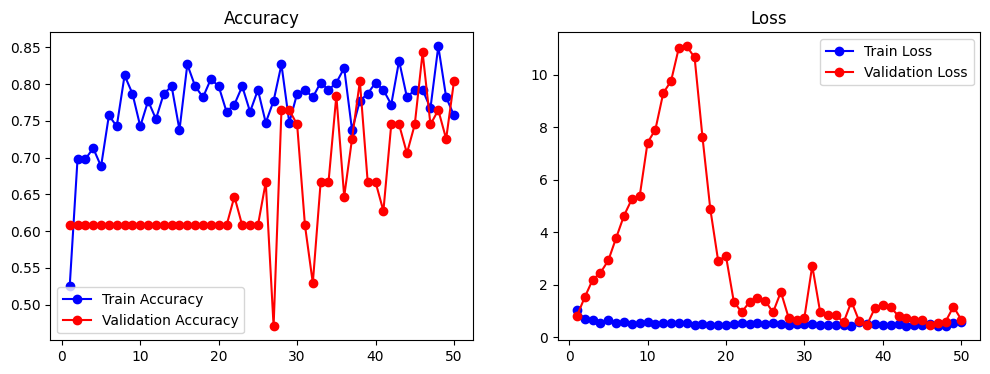

In [60]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confusion Matrix:
 [[ 4 16]
 [10 21]]
Classification Report:
               precision    recall  f1-score   support

    no_tumor       0.29      0.20      0.24        20
       tumor       0.57      0.68      0.62        31

    accuracy                           0.49        51
   macro avg       0.43      0.44      0.43        51
weighted avg       0.46      0.49      0.47        51



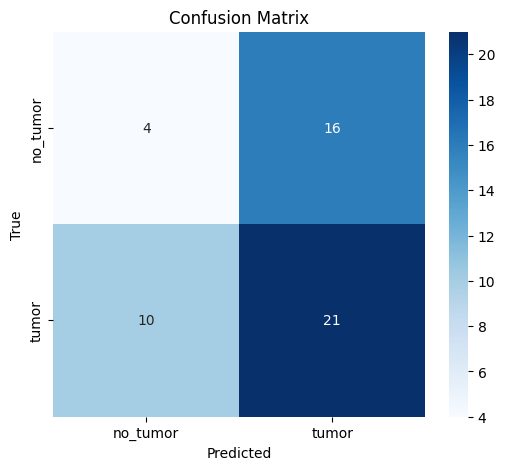

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on validation set
y_true = val_data.classes
val_data.reset()  # Important to reset generator
y_prob = model.predict(val_data, verbose=1)
y_pred = (y_prob > 0.5).astype(int).ravel()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
class_labels = list(val_data.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [75]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array /= 255.0
    return array

Building model graph...
Model graph built successfully!
Using last conv layer: conv2d_50

Generating predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Class names: ['no_tumor', 'tumor']

Correct Tumor: 23
Correct No Tumor: 6
Incorrect Tumor (False Negative): 8
Incorrect No Tumor (False Positive): 14

CORRECT PREDICTIONS


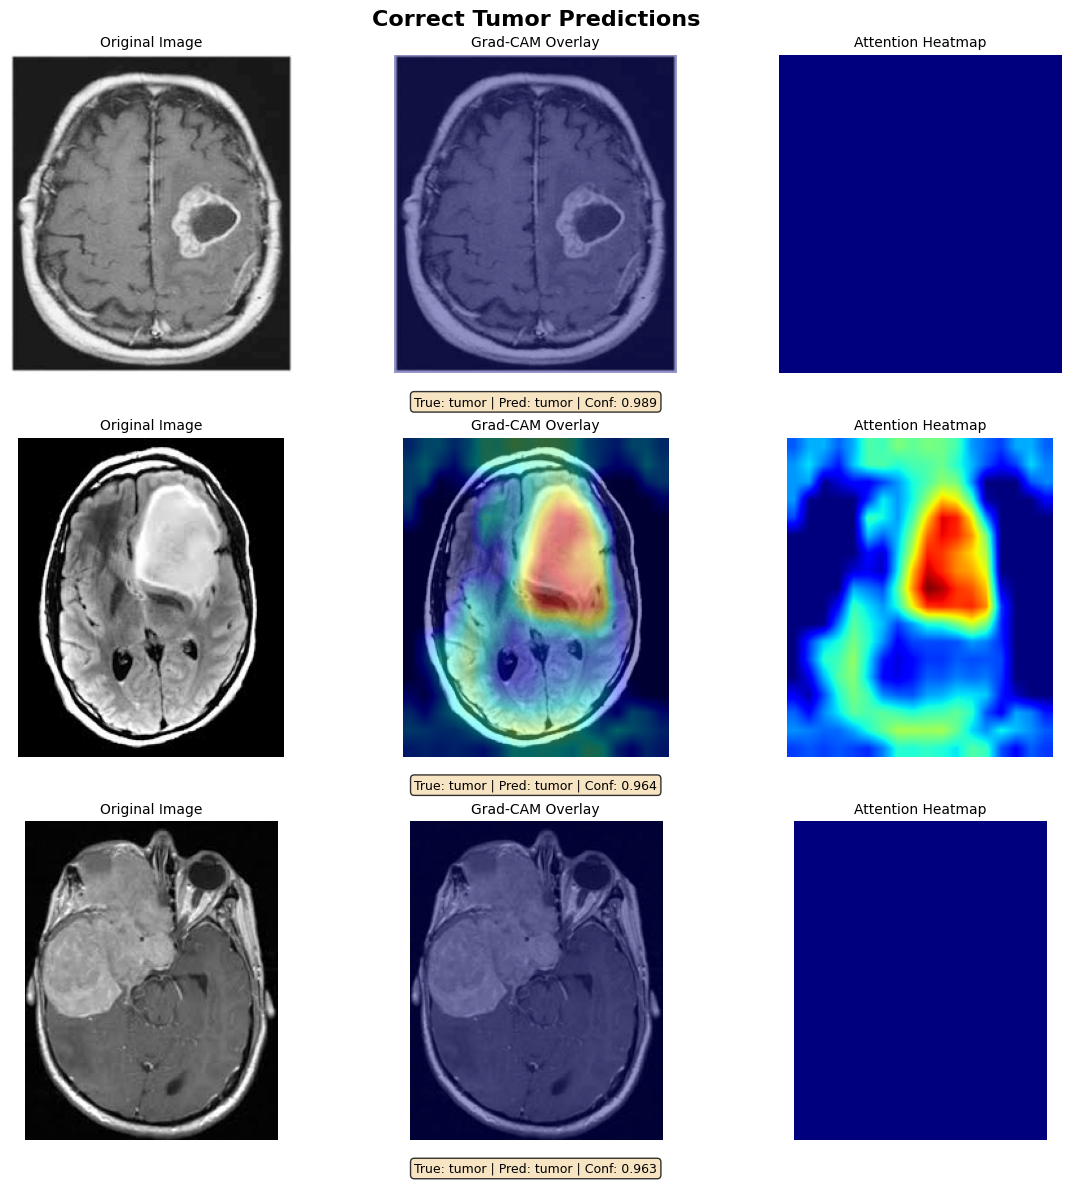

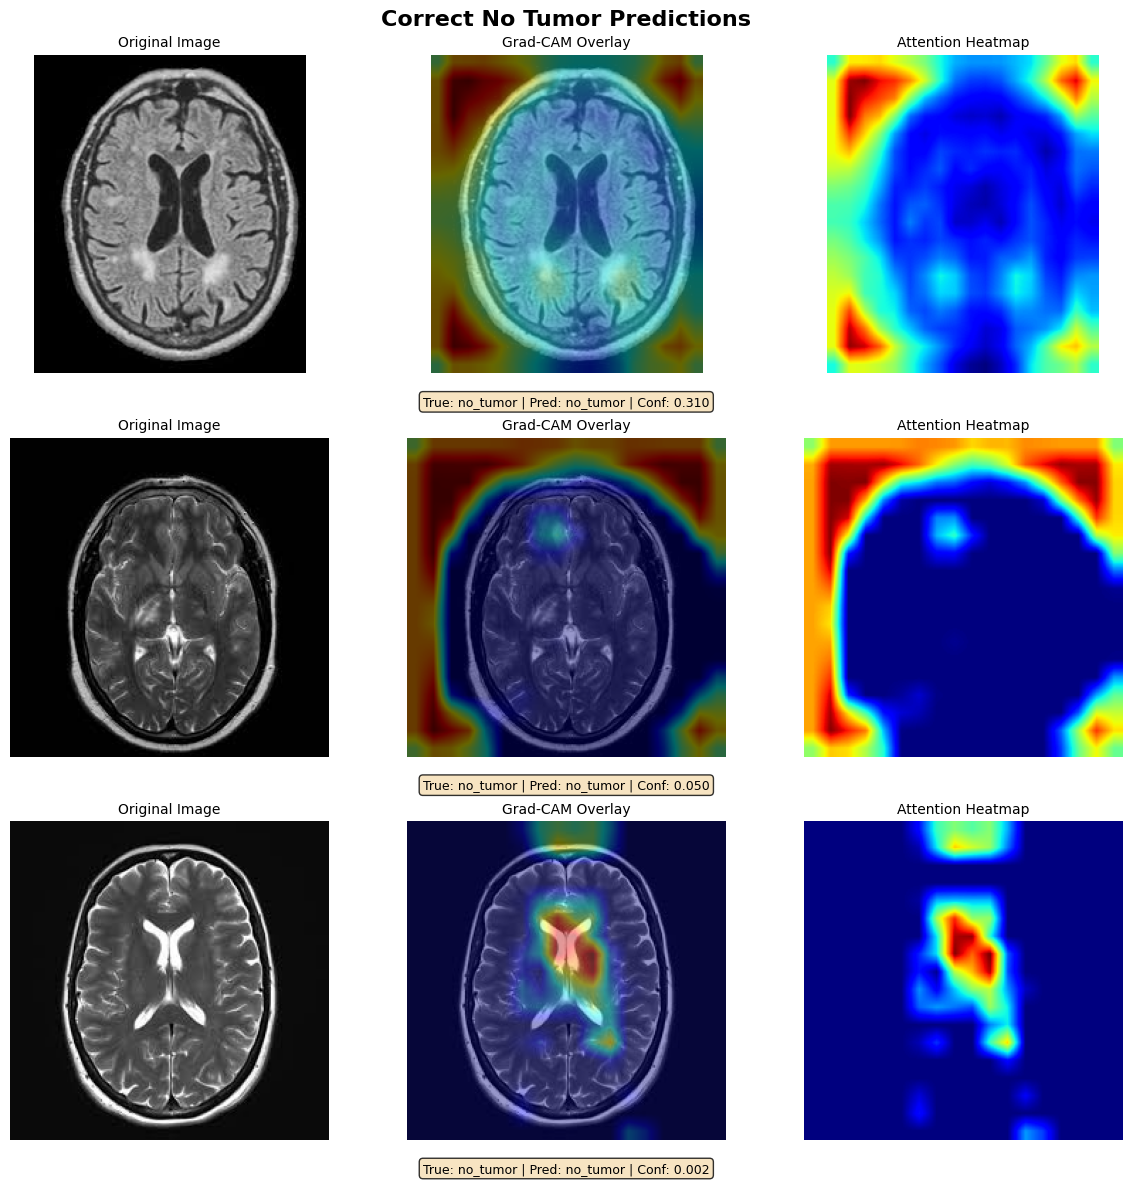


INCORRECT PREDICTIONS


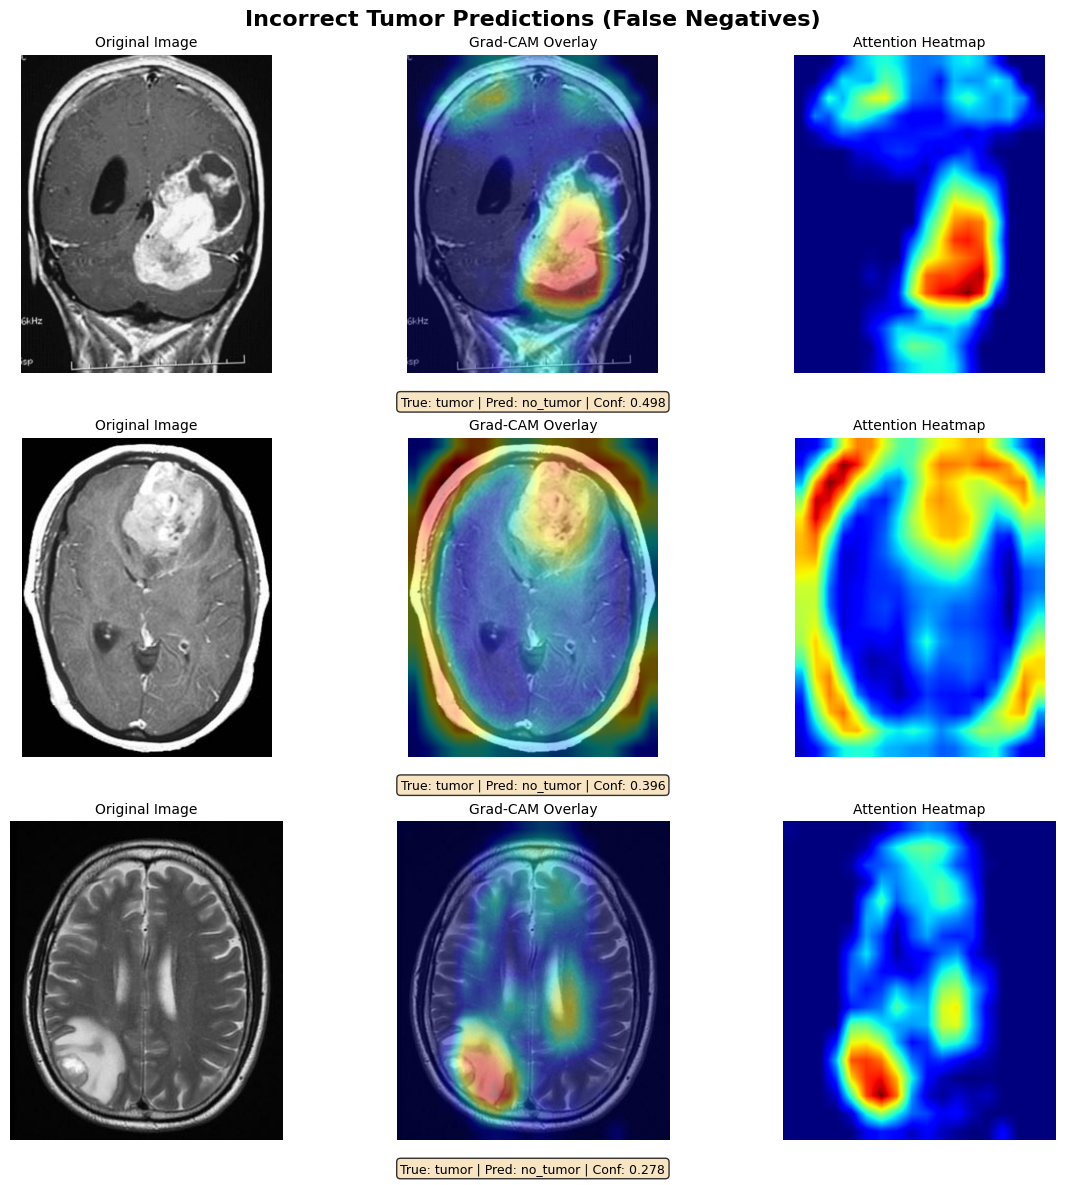

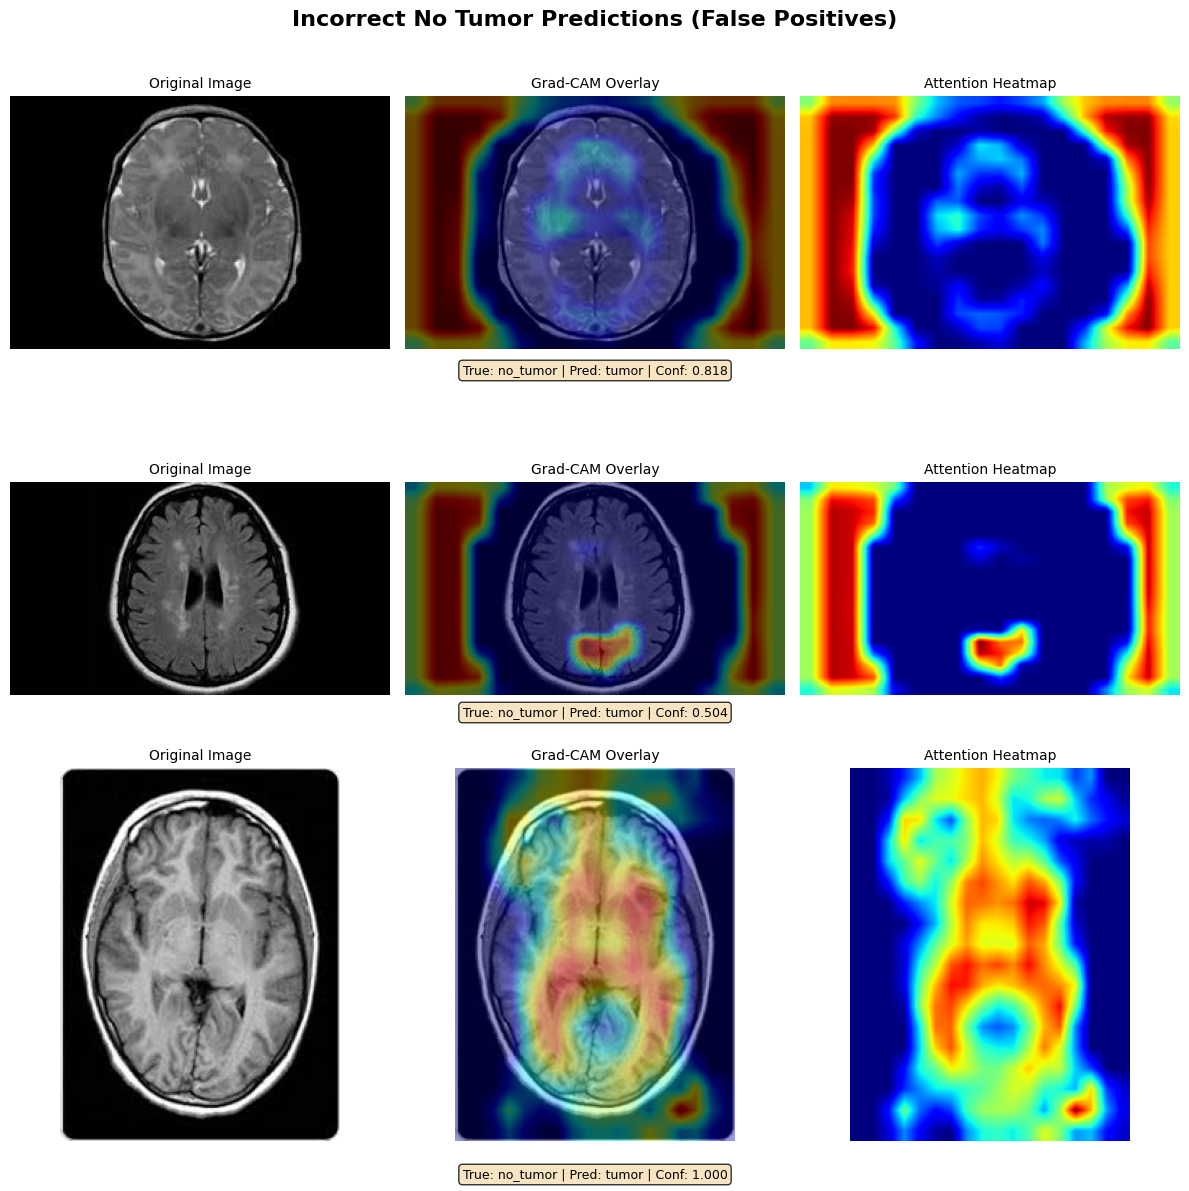


GRAD-CAM VISUALIZATION COMPLETE

Interpretation Guide:
- RED/YELLOW areas: High attention (model focuses here)
- BLUE/GREEN areas: Low attention (model ignores these)
- For tumors: Red should highlight tumor regions
- For no tumor: Attention should be distributed evenly


In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# CRITICAL FIX: Build the model properly using build() method
print("Building model graph...")
model.build((None, 150, 150, 3))
print("Model graph built successfully!")

# Find the last convolutional layer automatically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model!")

print(f"Using last conv layer: {last_conv_layer_name}")

# Alternative Grad-CAM function that works with Sequential models
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Generate Grad-CAM heatmap using functional approach."""

    # Find the target layer index
    layer_idx = None
    for idx, layer in enumerate(model.layers):
        if layer.name == last_conv_layer_name:
            layer_idx = idx
            break

    if layer_idx is None:
        raise ValueError(f"Layer {last_conv_layer_name} not found")

    # Create a new model from input to conv layer output
    conv_model = tf.keras.Model(
        inputs=model.inputs[0] if isinstance(model.inputs, list) else model.inputs,
        outputs=model.layers[layer_idx].output
    )

    # Create a model for the classifier part
    classifier_input = tf.keras.Input(shape=model.layers[layer_idx].output.shape[1:])
    x = classifier_input
    for layer in model.layers[layer_idx + 1:]:
        x = layer(x)
    classifier_model = tf.keras.Model(inputs=classifier_input, outputs=x)

    # Get conv layer outputs
    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        predictions = classifier_model(conv_outputs)
        loss = predictions[:, 0]

    # Get gradients
    grads = tape.gradient(loss, conv_outputs)

    # Pool gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(len(pooled_grads)):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Create heatmap
    heatmap = np.mean(conv_outputs, axis=-1)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)

    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    """Overlay heatmap on original image."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert to color
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Superimpose
    superimposed = heatmap_color * alpha + img * (1 - alpha)
    superimposed = np.uint8(superimposed)

    return img, superimposed, heatmap_resized

# Prepare validation data
print("\nGenerating predictions...")
val_data.reset()
y_true = val_data.classes
y_prob = model.predict(val_data, verbose=1)
y_pred = (y_prob > 0.5).astype(int).ravel()

# Get class names
class_names = list(val_data.class_indices.keys())
print(f"Class names: {class_names}")

# Collect predictions with paths
predictions = []
for i in range(len(y_true)):
    predictions.append({
        'path': val_data.filepaths[i],
        'true': y_true[i],
        'pred': y_pred[i],
        'prob': y_prob[i][0],
        'correct': y_true[i] == y_pred[i]
    })

# Separate by correctness and class
correct_tumor = [p for p in predictions if p['correct'] and p['true'] == 1]
correct_no_tumor = [p for p in predictions if p['correct'] and p['true'] == 0]
incorrect_tumor = [p for p in predictions if not p['correct'] and p['true'] == 1]
incorrect_no_tumor = [p for p in predictions if not p['correct'] and p['true'] == 0]

print(f"\nCorrect Tumor: {len(correct_tumor)}")
print(f"Correct No Tumor: {len(correct_no_tumor)}")
print(f"Incorrect Tumor (False Negative): {len(incorrect_tumor)}")
print(f"Incorrect No Tumor (False Positive): {len(incorrect_no_tumor)}")

# Visualization function
def visualize_gradcam(pred_list, title, num_samples=3):
    """Visualize Grad-CAM for predictions."""
    if len(pred_list) == 0:
        print(f"\nNo samples for: {title}")
        return

    # Take up to num_samples
    samples = pred_list[:min(num_samples, len(pred_list))]

    fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4*len(samples)))
    if len(samples) == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)

    for idx, pred in enumerate(samples):
        try:
            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(pred['path'], target_size=(150, 150))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array_normalized = np.expand_dims(img_array, axis=0) / 255.0

            # Generate Grad-CAM
            heatmap = make_gradcam_heatmap(img_array_normalized, model, last_conv_layer_name)
            original, overlay, heatmap_resized = overlay_heatmap(pred['path'], heatmap)

            # Plot original
            axes[idx, 0].imshow(original)
            axes[idx, 0].set_title('Original Image', fontsize=10)
            axes[idx, 0].axis('off')

            # Plot overlay
            axes[idx, 1].imshow(overlay)
            axes[idx, 1].set_title('Grad-CAM Overlay', fontsize=10)
            axes[idx, 1].axis('off')

            # Plot heatmap
            axes[idx, 2].imshow(heatmap_resized, cmap='jet')
            axes[idx, 2].set_title('Attention Heatmap', fontsize=10)
            axes[idx, 2].axis('off')

            # Add info text
            true_label = class_names[pred['true']]
            pred_label = class_names[pred['pred']]
            info = f"True: {true_label} | Pred: {pred_label} | Conf: {pred['prob']:.3f}"
            axes[idx, 1].text(0.5, -0.1, info, transform=axes[idx, 1].transAxes,
                             ha='center', fontsize=9,
                             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue

    plt.tight_layout()
    plt.show()

# Generate visualizations
print("\n" + "="*70)
print("CORRECT PREDICTIONS")
print("="*70)

visualize_gradcam(correct_tumor, "Correct Tumor Predictions", num_samples=3)
visualize_gradcam(correct_no_tumor, "Correct No Tumor Predictions", num_samples=3)

print("\n" + "="*70)
print("INCORRECT PREDICTIONS")
print("="*70)

visualize_gradcam(incorrect_tumor, "Incorrect Tumor Predictions (False Negatives)", num_samples=3)
visualize_gradcam(incorrect_no_tumor, "Incorrect No Tumor Predictions (False Positives)", num_samples=3)

print("\n" + "="*70)
print("GRAD-CAM VISUALIZATION COMPLETE")
print("="*70)
print("\nInterpretation Guide:")
print("- RED/YELLOW areas: High attention (model focuses here)")
print("- BLUE/GREEN areas: Low attention (model ignores these)")
print("- For tumors: Red should highlight tumor regions")
print("- For no tumor: Attention should be distributed evenly")

In [80]:
# Save the trained model
model.save("best_balanced_model.keras")
